In [1]:
# импорт модулей
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt 
%matplotlib inline

# читаем набор данных
data = pd.read_excel('C:\\Trash\\Programming\\gdpGROWTH.xls')

data.head()

,Date,China,France,Germany,Italy,Kazakhstan,Russia,Spain,USA
0,2004,10.2,2.8,1.2,1.4,9.6,7.2,3.1,3.8
1,2005,11.4,1.7,0.7,0.8,9.7,6.4,3.7,3.5
2,2006,12.7,2.4,3.8,1.8,10.7,8.2,4.1,2.9
3,2007,14.3,2.4,3.0,1.5,8.9,8.5,3.6,1.9
4,2008,9.7,0.3,1.0,-1.0,3.3,5.2,0.9,-0.1


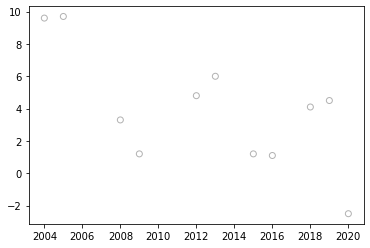

In [3]:
data_x = data['Date']
data_y = data['Kazakhstan']

# делим набор данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(data_x, data_y, test_size=0.33, random_state = 1)

# Визуализируем отношения возраста и заработной платы
import matplotlib.pyplot as plt
plt.scatter(train_x, train_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.show()


In [5]:
from sklearn.linear_model import LinearRegression

# обучаем модель регрессии
x = train_x.values.reshape(-1,1)
model = LinearRegression()
model.fit(x,train_y)
print(model.coef_)
print(model.intercept_)

[-0.44973483]
909.061756040071


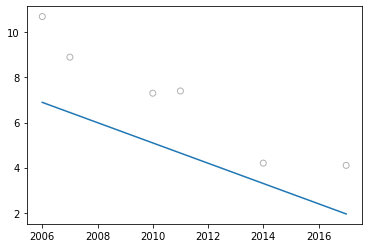

In [12]:
# Прогноз на тестовой выборке
valid_x = valid_x.reshape(-1,1)
pred = model.predict(valid_x)

# Визуализация
# Мы будем использовать 70 точек valid_x
xp = np.linspace(valid_x.min(),valid_x.max(),70)
xp = xp.reshape(-1,1)
pred_plot = model.predict(xp)

plt.scatter(valid_x, valid_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(xp, pred_plot)
plt.show()

In [13]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(valid_y, pred))
print(rms)

2.5307356333557207


[ 2.97584980e-02 -1.20199649e+02  1.21378359e+05]


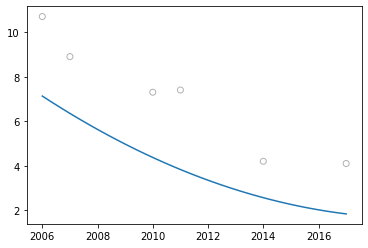

In [17]:
# Генерируем веса для полиномиальной функции степени 2
weights = np.polyfit(train_x, train_y, 2)
print(weights)

# Генерируем модель с данными весами
model = np.poly1d(weights)

# Прогноз на тестовой выборке
pred = model(valid_x)
# Строим график только для 70 наблюдений
xp = np.linspace(valid_x.min(),valid_x.max(),70)
pred_plot = model(xp)
plt.scatter(valid_x, valid_y, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(xp, pred_plot)
plt.show()

In [18]:
# Делим данные на 4 интервала
df_cut, bins = pd.cut(train_x, 4, retbins=True, right=True)
df_cut.value_counts(sort=False)

(2003.984, 2008.0]    3
(2008.0, 2012.0]      2
(2012.0, 2016.0]      3
(2016.0, 2020.0]      3
Name: Date, dtype: int64

In [19]:
df_steps = pd.concat([train_x, df_cut, train_y], keys=['Date','Date_cuts','Kazakhstan'], axis=1)

# Создаем фиктивные переменные для возрастных групп
df_steps_dummies = pd.get_dummies(df_cut)
df_steps_dummies.head()

    (2003.984, 2008.0]  (2008.0, 2012.0]  (2012.0, 2016.0]  (2016.0, 2020.0]
4                    1                 0                 0                 0
1                    1                 0                 0                 0
14                   0                 0                 0                 1
0                    1                 0                 0                 0
16                   0                 0                 0                 1

In [24]:
df_steps_dummies.columns = ['2003.984-2008.0','2008.0-2012.0','2012.0-2016.0','2016.0-2020.0'] 

# Подгоняем обобщенные линейные модели
fit3 = sm.GLM(df_steps.Kazakhstan, df_steps_dummies).fit()

In [33]:
# Разделяем тестовую выборку на 4 интервала
bin_mapping = np.digitize(valid_x, bins) 
bin_mapping1 = bin_mapping.flatten() 
X_valid = pd.get_dummies(bin_mapping1)

In [36]:
# Удаляем выбросы
X_valid
#X_valid = pd.get_dummies(bin_mapping1).drop([5], axis=1)

,1,2,3,4
0,1,0,0,0
1,0,0,0,1
2,0,1,0,0
3,1,0,0,0
4,0,1,0,0
5,0,0,1,0


In [37]:
# Прогноз
pred2 = fit3.predict(X_valid)

# Рассчитываем RMSE
from sklearn.metrics import mean_squared_error 
from math import sqrt 
rms = sqrt(mean_squared_error(valid_y, pred2)) 
print(rms) 

# Строим график только для 70 наблюдений
xp = np.linspace(valid_x.min(),valid_x.max()-1,70) 
bin_mapping = np.digitize(xp, bins) 
X_valid_2 = pd.get_dummies(bin_mapping) 
pred2 = fit3.predict(X_valid_2)

3.0569895624920256


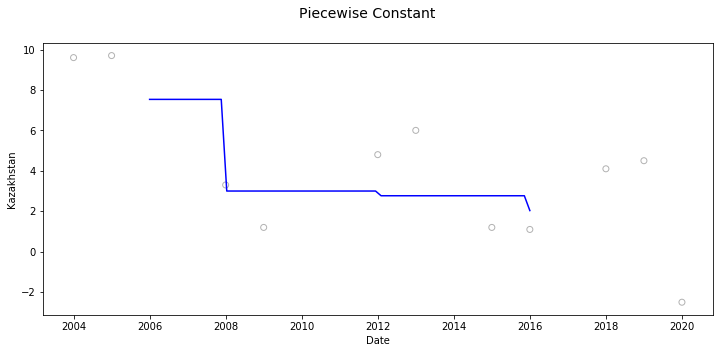

In [38]:
# Визуализация
fig, (ax1) = plt.subplots(1,1, figsize=(12,5))
fig.suptitle('Piecewise Constant', fontsize=14)

# График рассеяния с кривой полиномиальной регрессии
ax1.scatter(train_x, train_y, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(xp, pred2, c='b')

ax1.set_xlabel('Date')
ax1.set_ylabel('Kazakhstan')
plt.show()

In [53]:
# Visualizing the Linear Regression results
def viz_linear(x,y):
    plt.scatter(x, y, color='red')
    plt.plot(xp, pred2, color='blue')
    plt.title('Truth or Bluff (Linear Regression)')
    plt.xlabel('GDP per Year')
    plt.ylabel('Date')
    plt.show()
    return

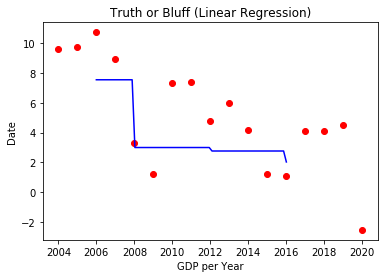

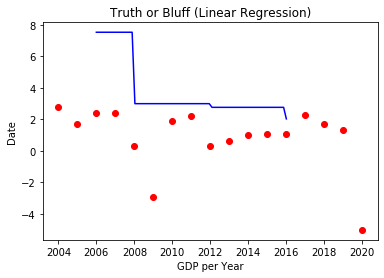

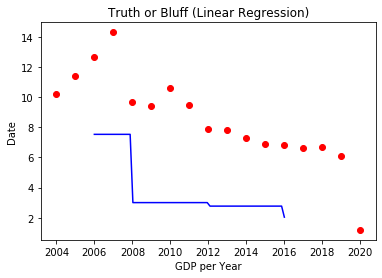

In [56]:
viz_linear(data[['Date']],data[['Kazakhstan']])
viz_linear(data[['Date']],data[['France']])
viz_linear(data[['Date']],data[['China']])

In [60]:
import numpy
from sklearn.metrics import r2_score
kz = numpy.poly1d(numpy.polyfit(data['Date'],data['Kazakhstan'], 3))
ch = numpy.poly1d(numpy.polyfit(data['Date'],data['China'], 3))
fra = numpy.poly1d(numpy.polyfit(data['Date'],data['France'], 3))
ita = numpy.poly1d(numpy.polyfit(data['Date'],data['Italy'], 3))
usa = numpy.poly1d(numpy.polyfit(data['Date'],data['USA'], 3))
rus = numpy.poly1d(numpy.polyfit(data['Date'],data['Russia'], 3))
sp = numpy.poly1d(numpy.polyfit(data['Date'],data['Spain'], 3))
ger = numpy.poly1d(numpy.polyfit(data['Date'],data['Germany'], 3))
gdp = kz(2021)
gdp1 = ch(2021)
gdp2 = ita(2021)
gdp3 = fra(2021)
gdp4 = usa(2021)
gdp5 = rus(2021)
gdp6 = sp(2021)
gdp7 = ger(2021)
print("Kazakhstan gpd in 2021 = ", gdp)
print("China gpd in 2021 = ",gdp1)
print("France gpd in 2021 = ",gdp2)
print("Italy gpd in 2021 = ",gdp3)
print("USA gpd in 2021 = ",gdp4)
print("Russia gpd in 2021 = ",gdp5)
print("Spain gpd in 2021 = ",gdp6)
print("Germany gpd in 2021 = ",gdp7)

Kazakhstan gpd in 2021 =  -1.3558825179934502
China gpd in 2021 =  2.858823448419571
France gpd in 2021 =  -6.755882382392883
Italy gpd in 2021 =  -4.957353100180626
USA gpd in 2021 =  -3.841176375746727
Russia gpd in 2021 =  -1.285294309258461
Spain gpd in 2021 =  -6.68235319852829
Germany gpd in 2021 =  -6.383823662996292
